In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import CrackSegmentationDataset
from network import SegmentationNetwork
from temperature_scaling import ModelWithTemperature
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 


In [23]:
seed = 1
mc_samples = 5
# set random seed for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Load model
net = SegmentationNetwork(num_classes=2, p = 0.5, backbone = 'resnet50', pretrained = True)

In [13]:
# Load model weights
def load_model_weights(net, path):
    state_dict = torch.load(path)
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    net.load_state_dict(state_dict)
    return net

In [14]:
# Load test dataset
root_dir = '/~/HDD1/rrathnak/CAAP_Stereo/Datasets/crack_segmentation_dataset'
crop_size = 224
num_classes = 2

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

data_transforms = A.Compose(
    [
        A.Resize(crop_size, crop_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
import numpy as np
from torchmetrics import F1Score, Accuracy, PrecisionRecallCurve, CalibrationError
from netcal.metrics import ECE

# Metrics for evaluation
F1_score = F1Score(mdmc_average='samplewise', average = 'macro',num_classes=num_classes)
F1_score_classwise = F1Score(average = 'none', num_classes = num_classes, mdmc_average='samplewise')
accuracy = Accuracy(mdmc_average='samplewise', num_classes = num_classes, average = 'macro')
accuracy_classwise = Accuracy(average = 'none', num_classes = num_classes, mdmc_average='samplewise')

In [15]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh



In [16]:
def test(
    net, test_loader, num_classes, mc_samples, train_len,
    summary_logger, input_modalities, device, 
    F1_score, F1_score_classwise, accuracy, accuracy_classwise
):
    # Batchwise_* is a list of size num_batches
    batchwise_F1 = []
    batchwise_F1_classwise = []
    batchwise_accuracy = []
    batchwise_accuracy_classwise = []
    batchwise_epistemic = []
    batchwise_epistemic_classwise = []
    batchwise_aleatoric = []
    batchwise_aleatoric_classwise = []
    batchwise_ece = []
    batchwise_entropy = []
    softmax = nn.Softmax(dim = 1)
    with torch.no_grad():
        for iter, (img_name, input_data, target) in enumerate(test_loader):
            # Inside a batch
            sampled_outs = []
            means = []
            means_noSoftmax = []
            sample_F1 = []
            sample_F1_classwise = []
            sample_accuracy = []
            sample_accuracy_classwise = []
            sample_ece = []
            for modality in input_modalities:
                input_data[modality] = input_data[modality].to(device)
            target = target.to(device)
            # Predicted aleatoric variance from a single pass
            batch_aleatoric_uncertainty = net(input_data)[:, num_classes:, :, :]
            assert batch_aleatoric_uncertainty.shape[1] == num_classes, "Aleatoric uncertainty shape error."
            batch_aleatoric_uncertainty = np.exp(batch_aleatoric_uncertainty.detach().clone().cpu().numpy())
            for i in range(mc_samples):
                # Iterate over MC samples
                sampled_outs.append(net(input_data))
            for out in sampled_outs:
                # For each sample, compute metrics for the mean prediction
                N, C, H, W = out.shape
                mean = out[:, :num_classes, :, :]
                # append mean prediction to list
                means_noSoftmax.append(mean.detach().clone().cpu().numpy())
                mean = softmax(mean)
                assert torch.allclose(mean.sum(dim = 1), torch.ones(N, H, W).to(device)), "AssertionError: Probabilities do not sum to 1"
                means.append(mean.detach().clone().cpu().numpy())
                f1_score = F1_score(mean.detach().cpu(), target.cpu()).numpy()
                f1_score_ = F1_score(out[:, :num_classes, :, :].detach().cpu(), target.cpu()).numpy()
                assert np.allclose(f1_score, f1_score_), "AssertionError: F1 score is not the same between softmax mean and out"
                f1_score_classwise = F1_score_classwise(mean.detach().cpu(), target.cpu()).numpy()
                acc = accuracy(mean.detach().cpu(), target.cpu()).numpy()
                acc_classwise = accuracy_classwise(mean.detach().cpu(), target.cpu()).numpy()
                sample_F1.append(f1_score)
                sample_F1_classwise.append(f1_score_classwise)
                sample_accuracy.append(acc)
                sample_accuracy_classwise.append(acc_classwise)
                # compute ECE
                # temperature = TemperatureScaling()
                # temperature.fit(mean.detach().cpu().numpy(), target.cpu().numpy())
                # calibrated = temperature.transform(mean.detach().cpu().numpy())
                n_bins = 30
                ece = CalibrationError(n_bins)
                ece.update(mean.detach().cpu(), target.cpu())
                sample_ece.append(ece.compute())
            # Computation for the batch is complete - append to list
            batch_mean = np.mean(np.stack(means), axis = 0)
            N, C, H, W = batch_mean.shape
            pred = batch_mean.transpose(0, 2, 3, 1).reshape(-1, num_classes).argmax(axis = 1).reshape(N, H, W)
            batch_F1 = np.mean(sample_F1, axis = 0)
            batch_F1_classwise = np.mean(sample_F1_classwise, axis = 0)
            batch_accuracy = np.mean(sample_accuracy, axis = 0)
            batch_accuracy_classwise = np.mean(sample_accuracy_classwise, axis = 0)
            batch_epistemic_uncertainty = np.var(np.stack(means), axis = 0)
            batch_epistemic_uncertainty_v2 = 1/mc_samples * np.sum(np.square(np.stack(means) - batch_mean), axis = 0)
            assert np.allclose(batch_epistemic_uncertainty, batch_epistemic_uncertainty_v2), "AssertionError: Epistemic uncertainty is not the same between two methods"
            # Compute entropy of the mean prediction
            batch_entropy = -np.sum(batch_mean * np.log(batch_mean), axis = 1)
            batch_epistemic_uncertainty_classwise = np.mean(batch_epistemic_uncertainty, axis = (0,2,3))
            batch_aleatoric_uncertainty_classwise = np.mean(batch_aleatoric_uncertainty, axis = (0,2,3))
            batch_ece = np.mean(sample_ece, axis = 0)
            # Append batch metrics to list (batchwise_*)
            batchwise_F1.append(batch_F1)
            batchwise_F1_classwise.append(batch_F1_classwise)
            batchwise_accuracy.append(batch_accuracy)
            batchwise_accuracy_classwise.append(batch_accuracy_classwise)
            batchwise_epistemic.append(batch_epistemic_uncertainty)
            batchwise_epistemic_classwise.append(batch_epistemic_uncertainty_classwise)
            batchwise_aleatoric.append(batch_aleatoric_uncertainty)
            batchwise_aleatoric_classwise.append(batch_aleatoric_uncertainty_classwise)
            batchwise_ece.append(batch_ece)
            batchwise_entropy.append(batch_entropy)
    # compute the average accuracy and f1 score for the entire TEST SET
    epoch_acc = np.mean(batchwise_accuracy)
    epoch_F1 = np.mean(batchwise_F1)
    epoch_classwise_F1 = np.mean(batchwise_F1_classwise, axis = 0)
    epoch_classwise_accuracy = np.mean(batchwise_accuracy_classwise, axis = 0)
    epoch_epistemic = np.mean(np.vstack(batchwise_epistemic))
    epoch_entropy = np.mean(np.vstack(batchwise_entropy))
    epoch_epistemic_classwise = np.mean(batchwise_epistemic_classwise, axis = 0)
    epoch_aleatoric = np.mean(np.vstack(batchwise_aleatoric))
    epoch_aleatoric_classwise = np.mean(batchwise_aleatoric_classwise, axis = 0)
    epoch_ece = np.mean(np.vstack(batchwise_ece))
    print("Length of training set:{}".format(train_len))
    print("Accuracy: {} | F1: {}".format(epoch_acc, epoch_F1))
    print("Epistemic Uncertainty: {} | Entropy: {} | Aleatoric Uncertainty: {}".format(epoch_epistemic, epoch_entropy,epoch_aleatoric))
    return epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1

In [17]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [18]:
import matplotlib.pyplot as plt

def create_subplots(nrows, ncols, figsize=(10,10), title='', xlabel='', ylabel='', titles=[], xlabels=[], ylabels=[]):
    """
    Create a figure with subplots of the specified number of rows and columns.
    :param nrows: number of rows for the subplots
    :param ncols: number of columns for the subplots
    :param figsize: size of the figure (width, height)
    :param title: title for the figure
    :param xlabel: x-axis label for all subplots
    :param ylabel: y-axis label for all subplots
    :param titles: list of titles for each subplot
    :param xlabels: list of x-axis labels for each subplot
    :param ylabels: list of y-axis labels for each subplot

    :return: figure and axes objects
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.expand_dims(axes , axis=0) if nrows == 1 else axes
    fig.set_dpi(300)
    fig.suptitle(title)
    
    if nrows == 1 and ncols == 1:
        # single subplot
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        if titles:
            axes.set_title(titles[0])
    else:
        # multiple subplots
        for i in range(nrows):
            for j in range(ncols):
                idx = i*ncols + j
                if xlabels:
                    axes[i, j].set_xlabel(xlabels[idx])
                else:
                    axes[i, j].set_xlabel(xlabel)
                if ylabels:
                    axes[i, j].set_ylabel(ylabels[idx])
                else:
                    axes[i, j].set_ylabel(ylabel)
                if titles:
                    axes[i, j].set_title(titles[idx])
    return fig, axes


# Result 1: Comparing the baseline MC Dropout, ABL IOU Loss addition and Temperature Scaling on DeepCrack and CrackForest

In [101]:
import numpy as np
# Table 1
import pandas as pd


models = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-13_resnet50_CFD_allTrain_0.4Dropout/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-13_resnet50_CFD_allTrain_0.4Dropout_ABLIOUSegLoss/best/best_model.pth'
]
datasets = [
    'DeepCrack',
    'DeepCrack',
    'CFD',
    'CFD'
]

model_F1 = []
model_epistemic = []
model_entropy = []
model_aleatoric = []
model_ece = []

for dataset, model_path in zip(datasets, models):
    p = 0.4
    # Load model
    print('MODEL_PATH: ', model_path)
    print('DATASET: ', dataset)
    print('Dropout: ', p)
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = dataset,
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_F1.append(epoch_F1)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    model_aleatoric.append(epoch_aleatoric)
    model_ece.append(epoch_ece)
# Tempertaure scaling - only for ABLIOU model in DeepCrack dataset
torch.cuda.empty_cache() 
p = 0.4
net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
net = load_model_weights(net, models[1])
input_modalities = ['rgb']
test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
# Temperature scaling
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net_with_temperature = ModelWithTemperature(net)
net_with_temperature = net_with_temperature.set_temperature(test_loader, num_classes = 2)
net_with_temperature.to(device)
net_with_temperature.model.eval()
net_with_temperature.model.dropout.train()
epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net_with_temperature,
test_loader = test_loader,
num_classes = num_classes,
mc_samples = mc_samples,
train_len = None,
summary_logger = None,
input_modalities = input_modalities,
device = device,
F1_score = F1_score,
F1_score_classwise = F1_score_classwise,
accuracy = accuracy,
accuracy_classwise = accuracy_classwise)
model_F1.append(epoch_F1)
model_epistemic.append(epoch_epistemic)
model_entropy.append(epoch_entropy)
model_aleatoric.append(epoch_aleatoric)
model_ece.append(epoch_ece)

# Tempertaure scaling - only for ABLIOU model for CFD
torch.cuda.empty_cache() 
p = 0.4
net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
net = load_model_weights(net, models[1])
input_modalities = ['rgb']
test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'CFD',
transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
# Temperature scaling
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net_with_temperature = ModelWithTemperature(net)
net_with_temperature = net_with_temperature.set_temperature(test_loader, num_classes = 2)
net_with_temperature.to(device)
net_with_temperature.model.eval()
net_with_temperature.model.dropout.train()
epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net_with_temperature,
test_loader = test_loader,
num_classes = num_classes,
mc_samples = mc_samples,
train_len = None,
summary_logger = None,
input_modalities = input_modalities,
device = device,
F1_score = F1_score,
F1_score_classwise = F1_score_classwise,
accuracy = accuracy,
accuracy_classwise = accuracy_classwise)
model_F1.append(epoch_F1)
model_epistemic.append(epoch_epistemic)
model_entropy.append(epoch_entropy)
model_aleatoric.append(epoch_aleatoric)
model_ece.append(epoch_ece)


MODEL_PATH:  /~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout/best/best_model.pth
DATASET:  DeepCrack
Dropout:  0.4
Length of training set:None
Accuracy: 0.9374414086341858 | F1: 0.7088916301727295
Epistemic Uncertainty: 0.0003139296604786068 | Entropy: 0.10523679852485657 | Aleatoric Uncertainty: 1.0213959217071533
MODEL_PATH:  /~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout_ABLIOUSegLoss/best/best_model.pth
DATASET:  DeepCrack
Dropout:  0.4
Length of training set:None
Accuracy: 0.9516286253929138 | F1: 0.8006115555763245
Epistemic Uncertainty: 0.0001898684276966378 | Entropy: 0.08405468612909317 | Aleatoric Uncertainty: 1.031089425086975
MODEL_PATH:  /~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-13_resnet50_CFD_allTrain_0.4Dropout/best/best_model.pth
DATASET:  CFD
Dropout:  0.4
Length of training set:None
Accuracy: 0.9362127184867859 | F1: 0.63858

In [104]:

dataframe_1 = pd.DataFrame()
# Initialize Columns of dataframe : Dataset, Model, F1-score, Uncertainties, ECE
dataframe_1['Dataset'] = ['DeepCrack', 'DeepCrack', 'DeepCrack', 'CFD', 'CFD', 'CFD']
dataframe_1['Model'] = ['MC Dropout w/ Aleatoric Uncertainty', 'Boundary Loss + IOU (BL + IOU)', 'Temperature Scaled BL + IOU', 'MC Dropout w/ Aleatoric Uncertainty', 'Boundary Loss + IOU (BL + IOU)', 'Temperature Scaled BL + IOU']
dataframe_1['F1-score'] = model_F1
dataframe_1['Epistemic Uncertainty'] = model_epistemic
dataframe_1['Entropy'] = model_entropy
dataframe_1['Aleatoric Uncertainty'] = model_aleatoric
dataframe_1['ECE'] = model_ece
dataframe_1 = dataframe_1.round(4)
# Convert to latex format
print(dataframe_1.to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
  Dataset &                               Model &  F1-score &  Epistemic Uncertainty &  Entropy &  Aleatoric Uncertainty &    ECE \\
\midrule
DeepCrack & MC Dropout w/ Aleatoric Uncertainty &    0.7089 &                 0.0003 &   0.1052 &                 1.0214 & 0.1466 \\
DeepCrack &      Boundary Loss + IOU (BL + IOU) &    0.8006 &                 0.0002 &   0.0841 &                 1.0311 & 0.1037 \\
DeepCrack &         Temperature Scaled BL + IOU &    0.6386 &                 0.0005 &   0.1331 &                 1.0366 & 0.0995 \\
      CFD & MC Dropout w/ Aleatoric Uncertainty &    0.6988 &                 0.0002 &   0.0828 &                 1.0134 & 0.0762 \\
      CFD &      Boundary Loss + IOU (BL + IOU) &    0.7958 &                 0.0002 &   0.1361 &                 1.0192 & 0.0901 \\
      CFD &         Temperature Scaled BL + IOU &    0.7462 &                 0.0002 &   0.1306 &                 1.0190 & 0.0336 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_1900722/686661786.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dataframe_1.to_latex(index=False))


# Result # 2: Across Training samples for the CrackForest Dataset


In [20]:
torch.cuda.empty_cache() 
# Iterate over all saved models and compute metrics
model_paths = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_5Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_25Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_50Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_75Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_allTrain_ABLIOUSegLoss/best/best_model.pth',
]
model_F1 = []
model_epistemic = []
model_entropy = []
model_aleatoric = []
model_ece = []
p = 0.5
for model_path in model_paths:
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    model_aleatoric.append(epoch_aleatoric)
    model_ece.append(epoch_ece)
    model_F1.append(epoch_F1)

for model_path in model_paths:
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'CFD',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    model_aleatoric.append(epoch_aleatoric)
    model_ece.append(epoch_ece)
    model_F1.append(epoch_F1)

/tmp/ipykernel_1902486/37031558.py:78: RuntimeWarning: divide by zero encountered in log
  batch_entropy = -np.sum(batch_mean * np.log(batch_mean), axis = 1)
/tmp/ipykernel_1902486/37031558.py:78: RuntimeWarning: invalid value encountered in multiply
  batch_entropy = -np.sum(batch_mean * np.log(batch_mean), axis = 1)


Length of training set:None
Accuracy: 0.6525359749794006 | F1: 0.5621717572212219
Epistemic Uncertainty: 0.0030959988944232464 | Entropy: nan | Aleatoric Uncertainty: 5.509970397223005e+23
Length of training set:None
Accuracy: 0.8788843154907227 | F1: 0.6472315192222595
Epistemic Uncertainty: 0.0019945537205785513 | Entropy: 0.25801926851272583 | Aleatoric Uncertainty: 1.006405234336853
Length of training set:None
Accuracy: 0.8249081969261169 | F1: 0.6551019549369812
Epistemic Uncertainty: 0.0005526841268874705 | Entropy: 0.1623929738998413 | Aleatoric Uncertainty: 1.0127637386322021
Length of training set:None
Accuracy: 0.8152639269828796 | F1: 0.6797778010368347
Epistemic Uncertainty: 0.0009299360681325197 | Entropy: 0.12903150916099548 | Aleatoric Uncertainty: 1.0150079727172852
Length of training set:None
Accuracy: 0.918872058391571 | F1: 0.7221286296844482
Epistemic Uncertainty: 0.0008146556210704148 | Entropy: 0.16803807020187378 | Aleatoric Uncertainty: 1.0065257549285889
Length

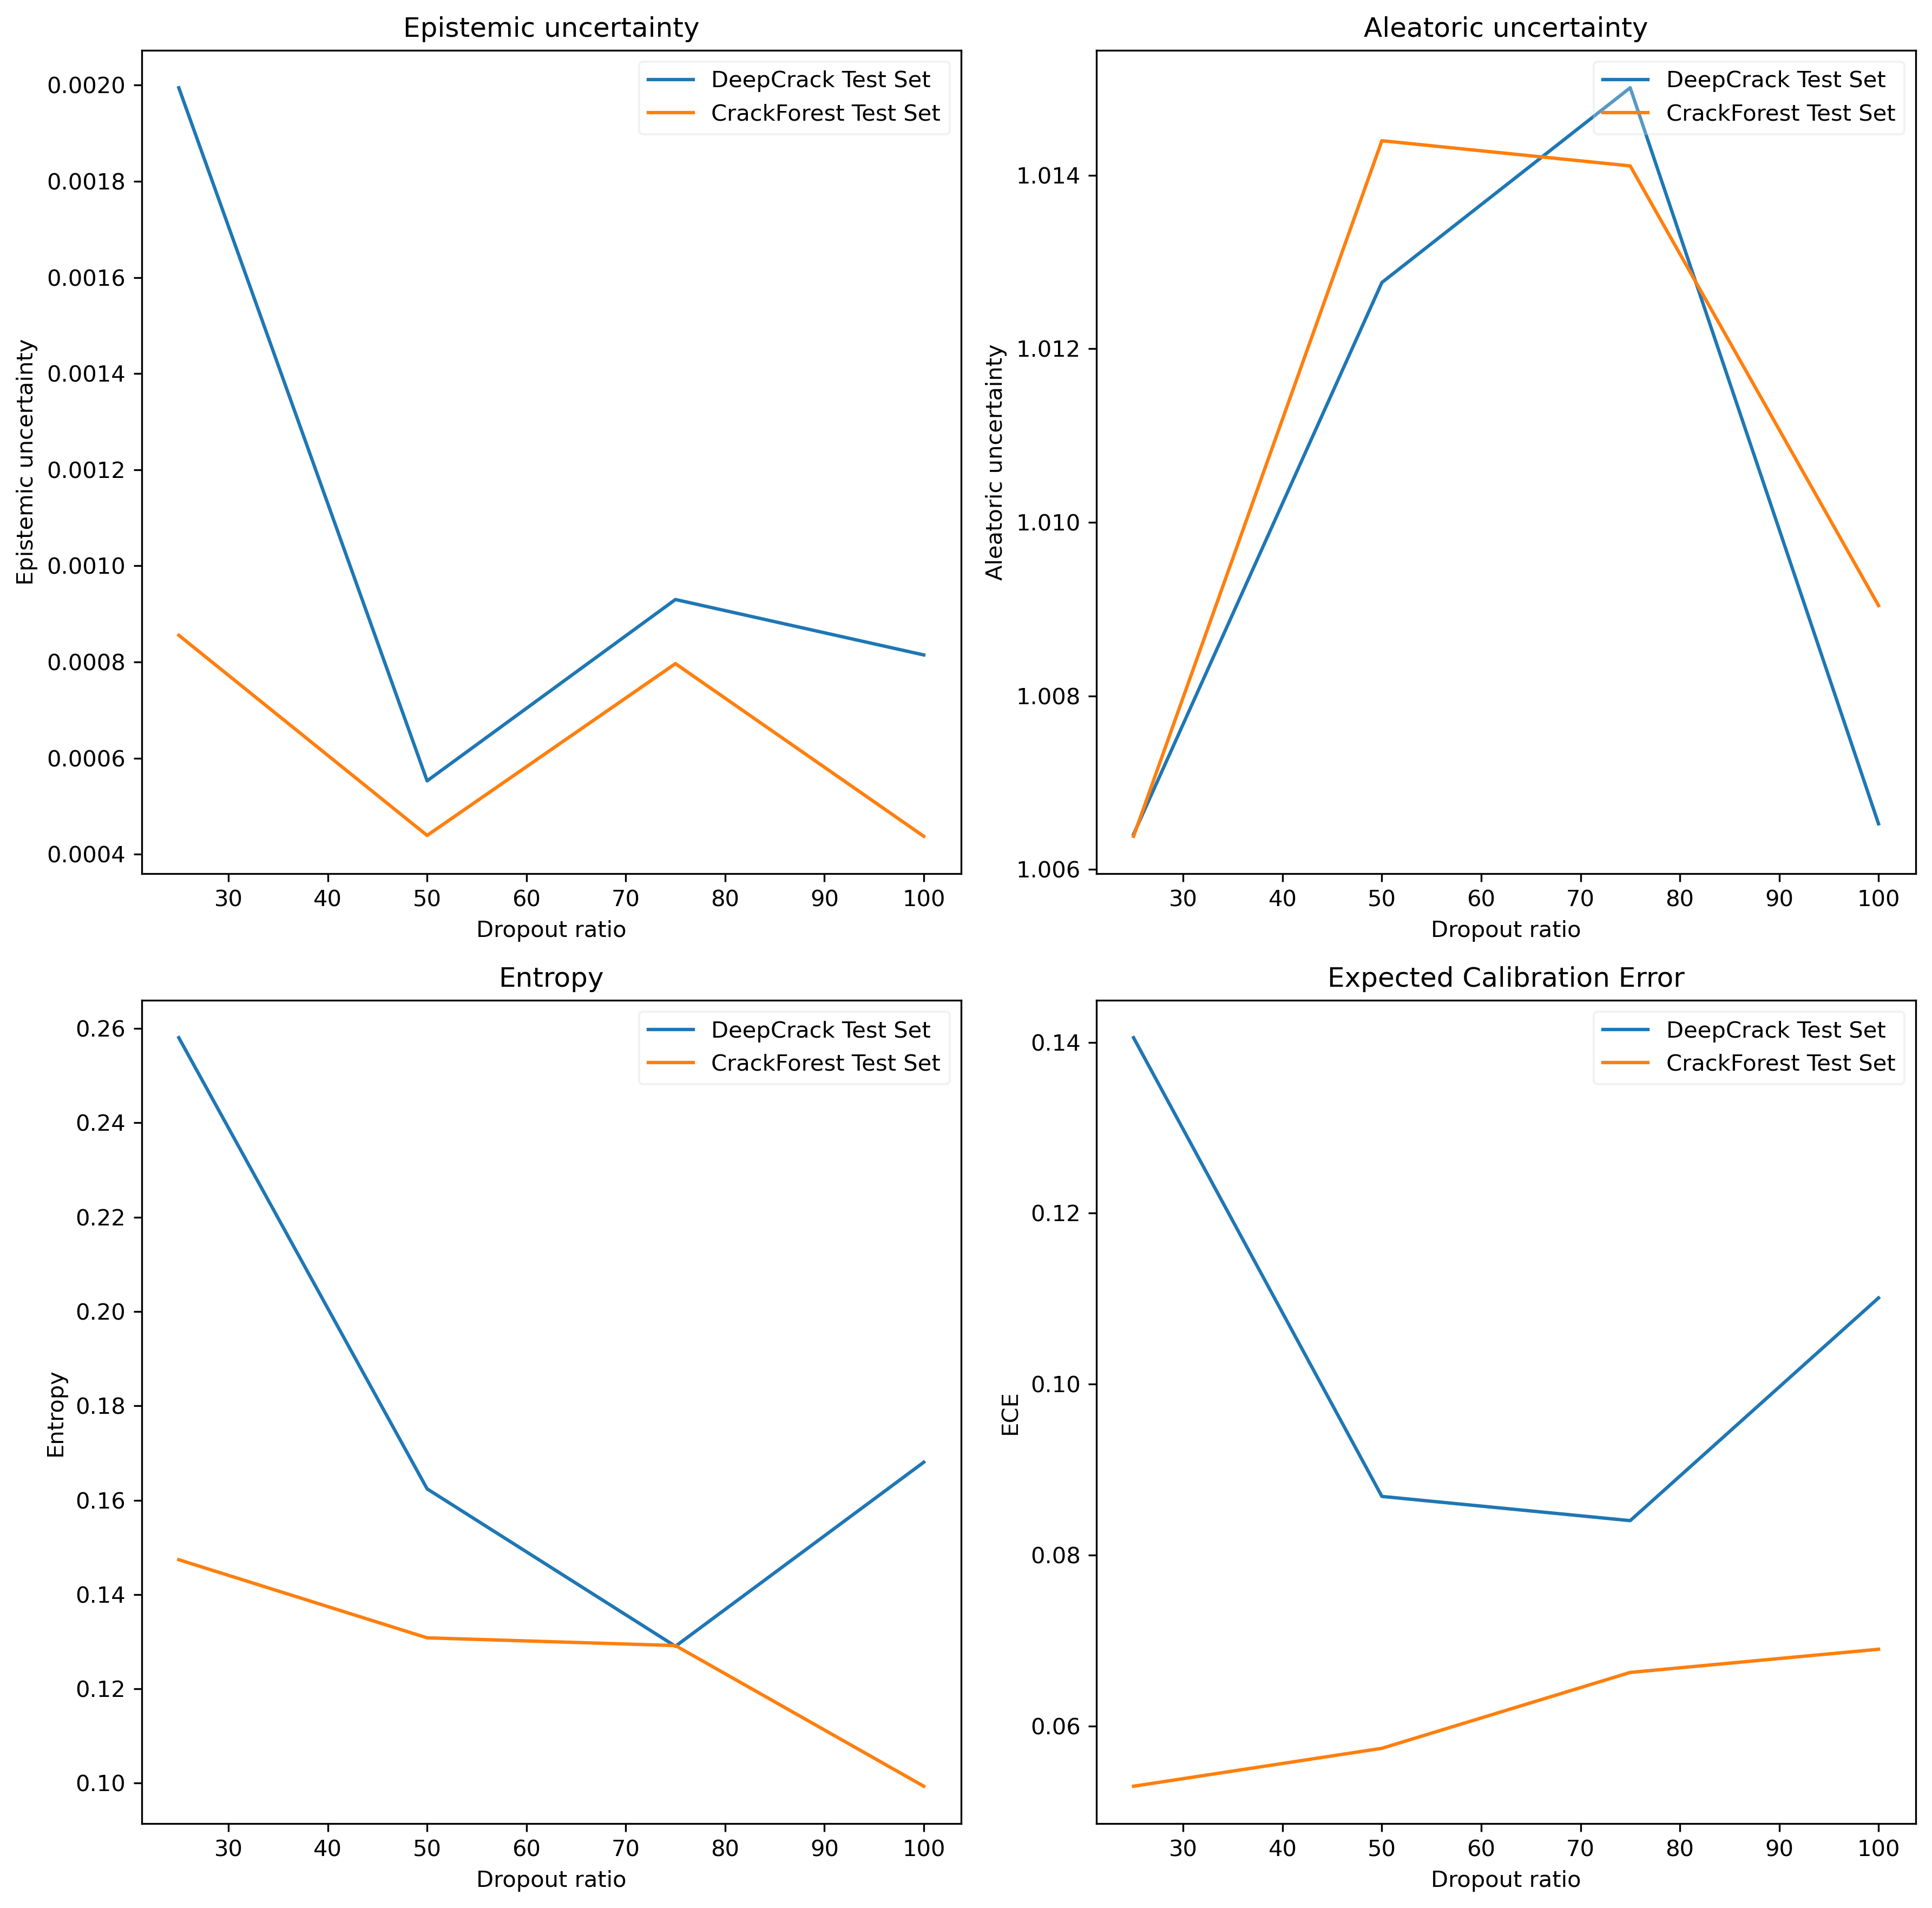

In [24]:
# Plot results using create_subplots function 
fig, axes = create_subplots(
    nrows = 2, ncols = 2, 
    figsize = (12, 12),
    # title = 'Model performance on DeepCrack dataset across dropout ratios',
    xlabel = 'Dropout ratio',
    ylabels = ['Epistemic uncertainty', 'Aleatoric uncertainty', 'Entropy', 'ECE'],
    titles = ['Epistemic uncertainty', 'Aleatoric uncertainty', 'Entropy', 'Expected Calibration Error']   
)
training_samples = [25, 50, 75, 100]
loc = 'upper right'
axes[0, 0].plot(training_samples, model_epistemic[1:5], label = 'DeepCrack Test Set')
axes[0, 0].plot(training_samples, model_epistemic[6:], label = 'CrackForest Test Set')
axes[0, 0].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[0, 1].plot(training_samples, model_aleatoric[1:5], label = 'DeepCrack Test Set')
axes[0, 1].plot(training_samples, model_aleatoric[6:], label = 'CrackForest Test Set')
axes[0, 1].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[1, 0].plot(training_samples, model_entropy[1:5], label = 'DeepCrack Test Set')
axes[1, 0].plot(training_samples, model_entropy[6:], label = 'CrackForest Test Set')
axes[1, 0].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[1, 1].plot(training_samples, model_ece[1:5], label = 'DeepCrack Test Set')
axes[1, 1].plot(training_samples, model_ece[6:], label = 'CrackForest Test Set')
axes[1, 1].legend(loc = loc, fancybox=True, framealpha=0.25)
plt.tight_layout()
plt.savefig('trainingSamples_CFDTrain_DeepCrackCFDEval.png')

# Result 2 (B) : Out of distribution performance - Baseline vs ABL-IOU model

In [25]:
torch.cuda.empty_cache() 
# Iterate over all saved models and compute metrics
model_paths = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-11-30_CrackForest25Train_resnet50_CrackForest/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-11-30_resnet50_CFD_50Train/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-11-30_resnet50_CFD_75Train/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2022-11-29_CrackForest100Train_resnet50_CrackForest/best/best_model.pth'
]
model_paths_abliou = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_25Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_50Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_75Train_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-03_resnet50_CFD_allTrain_ABLIOUSegLoss/best/best_model.pth',
]
model_F1 = []
model_epistemic = []
model_entropy = []
model_aleatoric = []
model_ece = []
p = 0.5
for model_path in model_paths:
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    model_aleatoric.append(epoch_aleatoric)
    model_ece.append(epoch_ece)
    model_F1.append(epoch_F1)

for model_path in model_paths_abliou:
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    model_aleatoric.append(epoch_aleatoric)
    model_ece.append(epoch_ece)
    model_F1.append(epoch_F1)

Length of training set:None
Accuracy: 0.7432813048362732 | F1: 0.6032705903053284
Epistemic Uncertainty: 0.0015429611084982753 | Entropy: 0.19619162380695343 | Aleatoric Uncertainty: 1285.4842529296875
Length of training set:None
Accuracy: 0.7808423042297363 | F1: 0.5699757933616638
Epistemic Uncertainty: 0.0019486031960695982 | Entropy: 0.27476730942726135 | Aleatoric Uncertainty: 1.0548712015151978
Length of training set:None
Accuracy: 0.8549131751060486 | F1: 0.6046590805053711
Epistemic Uncertainty: 0.001646641525439918 | Entropy: 0.2572205364704132 | Aleatoric Uncertainty: 1.0362988710403442
Length of training set:None
Accuracy: 0.8308407664299011 | F1: 0.6198998093605042
Epistemic Uncertainty: 0.0025276611559093 | Entropy: 0.25133997201919556 | Aleatoric Uncertainty: 2.3156747817993164
Length of training set:None
Accuracy: 0.8789886832237244 | F1: 0.6472533941268921
Epistemic Uncertainty: 0.0019938477780669928 | Entropy: 0.25798606872558594 | Aleatoric Uncertainty: 1.006448388099

In [ ]:
# Plot results using create_subplots function 
fig, axes = create_subplots(
    nrows = 1, ncols = 3, 
    figsize = (16, 6),
    # title = 'Model performance on DeepCrack dataset across dropout ratios',
    xlabel = 'Training samples',
    ylabels = ['Epistemic uncertainty', 'ECE', 'Entropy'],
    titles = ['Epistemic uncertainty', 'Expected Calibration Error', 'Entropy']   
)
training_samples = [25, 50, 75, 100]
loc = 'upper right'
axes[0, 0].plot(training_samples, model_epistemic[0:4], label = 'Baseline')
axes[0, 0].plot(training_samples, model_epistemic[4:], label = 'ABLIOU')
axes[0, 0].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[0, 1].plot(training_samples, model_ece[0:4], label = 'Baseline')
axes[0, 1].plot(training_samples, model_ece[4:], label = 'ABLIOU')
axes[0, 1].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[0, 2].plot(training_samples, model_entropy[0:4], label = 'Baseline')
axes[0, 2].plot(training_samples, model_entropy[4:], label = 'ABLIOU')
axes[0, 2].legend(loc = loc, fancybox=True, framealpha=0.25)
# axes[1, 1].plot(training_samples, model_ece[0:4], label = 'Baseline')
# axes[1, 1].plot(training_samples, model_ece[4:], label = 'ABLIOU')
# axes[1, 1].legend(loc = loc, fancybox=True, framealpha=0.25)
plt.tight_layout()
plt.savefig('trainingSamples_CFDTrain_CFDEval_BaselineVsABLIOU.png')

# RESULT 3 : Model performance, uncertainty and expected calibration error across dropout ratios evaluated on the DeepCrack Dataset+

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

torch.cuda.empty_cache() 
# Iterate over all saved models and compute metrics
model_paths_baseline = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.2Dropout/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.6Dropout/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.8Dropout/best/best_model.pth',
]

model_paths_abliou = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.2Dropout_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-12_resnet50_DeepCrack_allTrain_0.6Dropout_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.8Dropout_ABLIOUSegLoss/best/best_model.pth'
]

dropout_ratios = [0.2, 0.4, 0.6, 0.8]

model_F1 = []
model_epistemic = []
model_entropy = []
model_aleatoric = []
model_ece = []

model_F1_abliou = []
model_epistemic_abliou = []
model_entropy_abliou = []
model_aleatoric_abliou = []
model_ece_abliou = []

for p, model_path in zip(dropout_ratios, model_paths_baseline):
    # Load model
    print('MODEL_PATH: ', model_path)
    print('Dropout: ', p)
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_F1.append(epoch_F1)
    model_epistemic.append(epoch_epistemic)
    model_entropy.append(epoch_entropy)
    model_aleatoric.append(epoch_aleatoric)
    model_ece.append(epoch_ece)

print('Done with baseline models')
print('Results for ABLIOU models:')
for p, model_path in zip(dropout_ratios, model_paths_abliou):
    # Load model
    print('MODEL_PATH: ', model_path)
    print('Dropout: ', p)
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
    test_loader = test_loader,
    num_classes = num_classes,
    mc_samples = mc_samples,
    train_len = None,
    summary_logger = None,
    input_modalities = input_modalities,
    device = device,
    F1_score = F1_score,
    F1_score_classwise = F1_score_classwise,
    accuracy = accuracy,
    accuracy_classwise = accuracy_classwise)
    model_F1_abliou.append(epoch_F1)
    model_epistemic_abliou.append(epoch_epistemic)
    model_entropy_abliou.append(epoch_entropy)
    model_aleatoric_abliou.append(epoch_aleatoric)
    model_ece_abliou.append(epoch_ece)


print('Done with ABLIOU models')
# Save results to dataframe
df = pd.DataFrame({'Dropout': dropout_ratios, 'F1': model_F1, 'Epistemic': model_epistemic, 'Entropy': model_entropy, 'Aleatoric': model_aleatoric, 'ECE': model_ece})
df_abliou = pd.DataFrame({'Dropout': dropout_ratios, 'F1': model_F1_abliou, 'Epistemic': model_epistemic_abliou, 'Entropy': model_entropy_abliou, 'Aleatoric': model_aleatoric_abliou, 'ECE': model_ece_abliou})
df.to_csv('results_baseline_dropoutRatio_deepCrackEval.csv')
df_abliou.to_csv('results_abliou_dropoutRatio_deepCrackEval.csv')



MODEL_PATH:  /~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.2Dropout/best/best_model.pth
Dropout:  0.2
Length of training set:None
Accuracy: 0.9389006495475769 | F1: 0.7134856581687927
Epistemic Uncertainty: 0.00013592906179837883 | Entropy: 0.09935536980628967 | Aleatoric Uncertainty: 1.0108976364135742
MODEL_PATH:  /~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout/best/best_model.pth
Dropout:  0.4
Length of training set:None
Accuracy: 0.9374331831932068 | F1: 0.7088766098022461
Epistemic Uncertainty: 0.00026172189973294735 | Entropy: 0.10482490807771683 | Aleatoric Uncertainty: 1.0213440656661987
MODEL_PATH:  /~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.6Dropout/best/best_model.pth
Dropout:  0.6
Length of training set:None
Accuracy: 0.9363572001457214 | F1: 0.710909366607666
Epistemic Uncertainty: 0.0006152592832222581 | E

In [74]:
print(df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Dropout &        F1 &  Epistemic &   Entropy &  Aleatoric &       ECE \\
\midrule
0 &      0.2 &  0.713486 &   0.000136 &  0.099355 &   1.010898 &  0.145284 \\
1 &      0.4 &  0.708877 &   0.000262 &  0.104825 &   1.021344 &  0.146575 \\
2 &      0.6 &  0.710909 &   0.000615 &  0.126505 &   1.039880 &  0.140089 \\
3 &      0.8 &  0.707786 &   0.001355 &  0.139830 &  29.436886 &  0.137450 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1900722/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


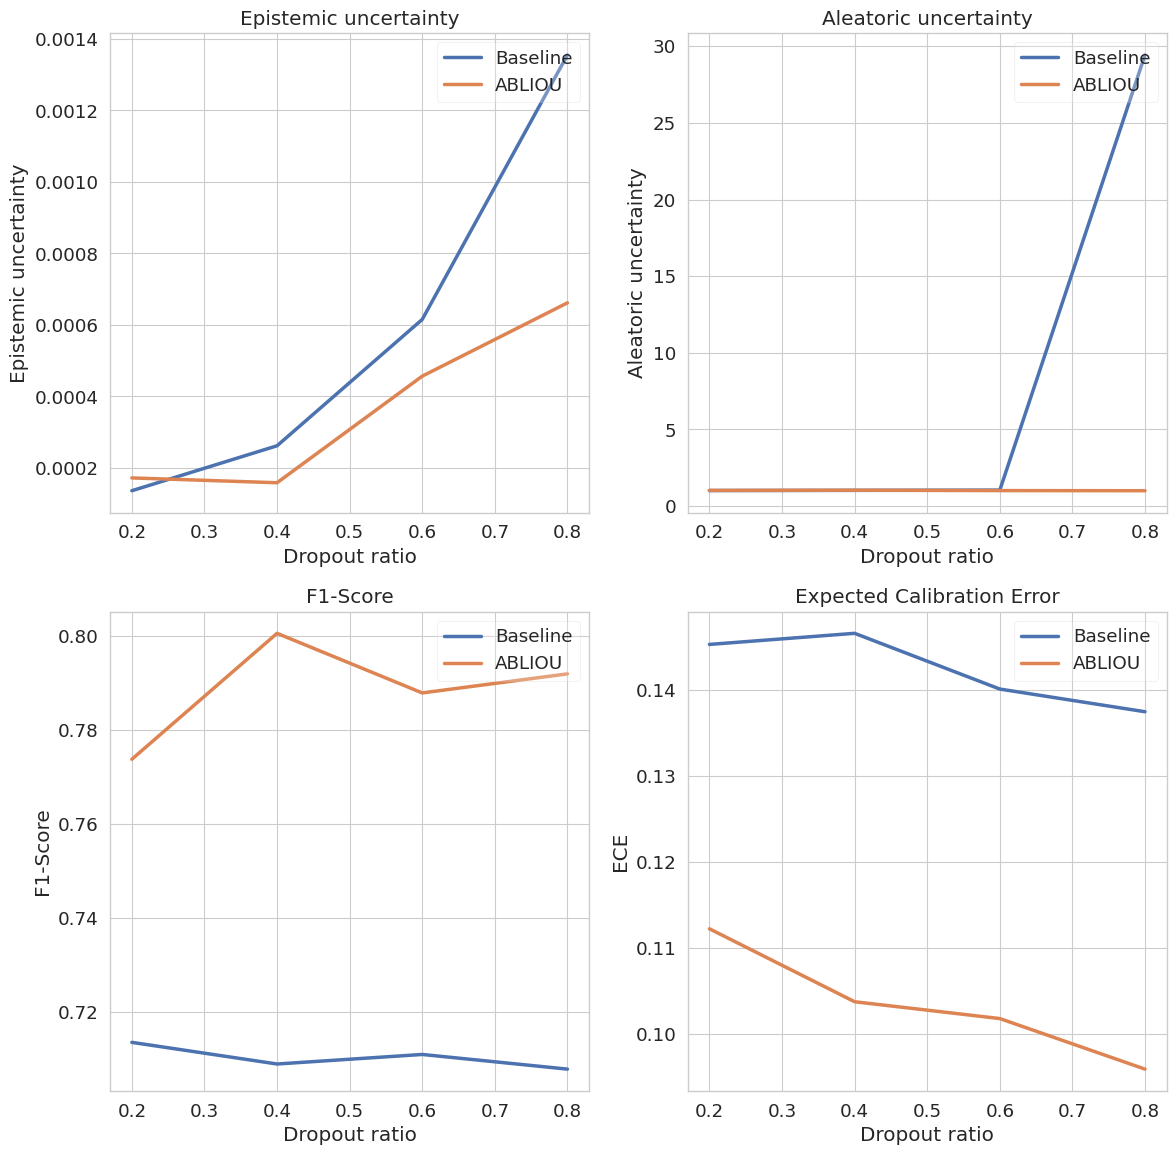

In [81]:
# Plot results using create_subplots function 
fig, axes = create_subplots(
    nrows = 2, ncols = 2, 
    figsize = (12, 12),
    # title = 'Model performance on DeepCrack dataset across dropout ratios',
    xlabel = 'Dropout ratio',
    ylabels = ['Epistemic uncertainty', 'Aleatoric uncertainty', 'F1-Score', 'ECE'],
    titles = ['Epistemic uncertainty', 'Aleatoric uncertainty', 'F1-Score', 'Expected Calibration Error']   
)
loc = 'upper right'
axes[0, 0].plot(dropout_ratios, model_epistemic, label = 'Baseline')
axes[0, 0].plot(dropout_ratios, model_epistemic_abliou, label = 'ABLIOU')
axes[0, 0].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[0, 1].plot(dropout_ratios, model_aleatoric, label = 'Baseline')
axes[0, 1].plot(dropout_ratios, model_aleatoric_abliou[~is_outlier(model_aleatoric_abliou)], label = 'ABLIOU')
axes[0, 1].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[1, 0].plot(dropout_ratios, model_F1, label = 'Baseline')
axes[1, 0].plot(dropout_ratios, model_F1_abliou, label = 'ABLIOU')
axes[1, 0].legend(loc = loc, fancybox=True, framealpha=0.25)
axes[1, 1].plot(dropout_ratios, model_ece, label = 'Baseline')
axes[1, 1].plot(dropout_ratios, model_ece_abliou, label = 'ABLIOU')
axes[1, 1].legend(loc = loc, fancybox=True, framealpha=0.25)
plt.tight_layout()
plt.savefig('dropout_ratio_deepCrackEval.png')

# Result 4: Detection examples: Image, Prediction, Ground Truth, Uncertainty - Baseline vs ABL IOU

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
torch.cuda.empty_cache() 

models = [
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.8Dropout_ABLIOUSegLoss/best/best_model.pth',
    '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.8Dropout/best/best_model.pth'
]
type = [
    'ABL-IOU',
    'Baseline'
]
p = 0.8
fig, axes = create_subplots(
    nrows = 4, ncols = 5,
    figsize = (36, 36),
    title = None,
    xlabel = None,
    ylabels = None,
    titles = None
)
sample_idx = np.random.choice(len(test_dataset), 2)
k = 0
for j, (model_type, model_path) in enumerate(zip(type, models)):
    # Load model
    print('MODEL_PATH: ', model_path)
    print('Dropout: ', p)
    net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
    net = load_model_weights(net, model_path)
    input_modalities = ['rgb']
    test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'CFD',
    transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    net.dropout.train()
    # Randomly sample 2 images from the test set and plot the results : Image,Prediction,Ground Truth, Epistemic Uncertanty, Aleatoric Uncertainty, Entropy
    for i, idx in enumerate(sample_idx):
        print('Sample index: ', idx)
        _, image, mask = test_dataset[idx]
        image = image['rgb'].to(device)
        mask = mask.to(device)
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        with torch.no_grad():
            # pass the image through the network mc_samples times
            image = image.repeat(mc_samples, 1, 1, 1)
            output = net(image)
            # reshape the output to be of shape (mc_samples, batch_size, num_classes, height, width)
            # mean over the mc_samples dimension
            mean_prediction = output[:, :num_classes, :, :].mean(0).unsqueeze(0)
            # variance over the mc_samples dimension
            epistemic_uncertainty = output[:, :num_classes, :, :].var(0)
            aleatoric_uncertainty = torch.exp(output[:, num_classes:, :, :].mean(0))
            # compute the entropy of the mean prediction
            entropy = -torch.sum(mean_prediction * torch.log(mean_prediction), axis = 1)
        # Plot image, mean_prediction, mask, epistemic_uncertainty, aleatoric_uncertainty, entropy
        N, H, W = 1, 224, 224
        image = image[0].cpu().numpy().transpose(1, 2, 0)
        mean_prediction = mean_prediction.cpu().numpy().transpose(0, 2, 3, 1).reshape(-1, num_classes).argmax(axis = 1).reshape(N, H, W)[0]
        mask = mask[0].cpu().numpy()
        epistemic_uncertainty = epistemic_uncertainty[0].cpu().numpy()
        aleatoric_uncertainty = aleatoric_uncertainty[0].cpu().numpy()
        entropy = entropy[0].cpu().numpy()
        axes[k, 0].imshow(image, cmap = 'gray')
        if k == 0:
            axes[k, 0].set_title('Image')
        axes[k, 0].axis('off')
        # Plot prediction
        axes[k, 1].imshow(mean_prediction)
        if k == 0:
            axes[k, 1].set_title('Prediction')
        axes[k, 1].axis('off')
        # Plot ground truth
        axes[k, 2].imshow(mask)
        if k == 0:
            axes[k, 2].set_title('Ground Truth')
        axes[k, 2].axis('off')
        # Plot epistemic uncertainty
        axes[k, 3].imshow(epistemic_uncertainty)
        if k == 0:
            axes[k, 3].set_title('Epistemic Uncertainty')
        axes[k, 3].axis('off')
        # Plot aleatoric uncertainty
        axes[k, 4].imshow(aleatoric_uncertainty)
        if k == 0:
            axes[k, 4].set_title('Aleatoric Uncertainty')
        axes[k, 4].axis('off')
        # # Plot entropy
        # axes[k, 5].imshow(entropy)
        # axes[k, 5].set_title('Entropy')
        # axes[k, 5].axis('off')
        k += 1
    plt.tight_layout()
    plt.savefig('dropout_ratio_deepCrackEval_{}_Demonstrations.png'.format(p))


# Result 5: Calibration of the model trained on CrackForest: Evaluate on CFD, DeepCrack, Noisy DeepCrack

In [34]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator,PercentFormatter
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12

models = [
   '/~/HDD1/rrathnak/CAAP_Stereo/MCDROPOUT_EXPERIMENTS/models/2023-01-11_resnet50_DeepCrack_allTrain_0.4Dropout_ABLIOUSegLoss/best/best_model.pth'
]
def test_calibration(
    net, test_loader, num_classes, mc_samples, train_len,
    summary_logger, input_modalities, device, 
    F1_score, F1_score_classwise, accuracy, accuracy_classwise
):
    # Batchwise_* is a list of size num_batches
    batchwise_F1 = []
    batchwise_F1_classwise = []
    batchwise_accuracy = []
    batchwise_accuracy_classwise = []
    batchwise_epistemic = []
    batchwise_epistemic_classwise = []
    batchwise_aleatoric = []
    batchwise_aleatoric_classwise = []
    batchwise_ece = []
    batchwise_entropy = []
    softmax = nn.Softmax(dim = 1)
    with torch.no_grad():
        for iter, (img_name, input_data, target) in enumerate(test_loader):
            # Inside a batch
            sampled_outs = []
            means = []
            means_noSoftmax = []
            sample_F1 = []
            sample_F1_classwise = []
            sample_accuracy = []
            sample_accuracy_classwise = []
            sample_ece = []
            for modality in input_modalities:
                input_data[modality] = input_data[modality].to(device)
            target = target.to(device)
            # Predicted aleatoric variance from a single pass
            batch_aleatoric_uncertainty = net(input_data)[:, num_classes:, :, :]
            assert batch_aleatoric_uncertainty.shape[1] == num_classes, "Aleatoric uncertainty shape error."
            batch_aleatoric_uncertainty = np.exp(batch_aleatoric_uncertainty.detach().clone().cpu().numpy())
            for i in range(mc_samples):
                # Iterate over MC samples
                sampled_outs.append(net(input_data))
            for out in sampled_outs:
                # For each sample, compute metrics for the mean prediction
                N, C, H, W = out.shape
                mean = out[:, :num_classes, :, :]
                # append mean prediction to list
                means_noSoftmax.append(mean.detach().clone().cpu().numpy())
                mean = softmax(mean)
                assert torch.allclose(mean.sum(dim = 1), torch.ones(N, H, W).to(device)), "AssertionError: Probabilities do not sum to 1"
                means.append(mean.detach().clone().cpu().numpy())
                f1_score = F1_score(mean.detach().cpu(), target.cpu()).numpy()
                f1_score_ = F1_score(out[:, :num_classes, :, :].detach().cpu(), target.cpu()).numpy()
                assert np.allclose(f1_score, f1_score_), "AssertionError: F1 score is not the same between softmax mean and out"
                f1_score_classwise = F1_score_classwise(mean.detach().cpu(), target.cpu()).numpy()
                acc = accuracy(mean.detach().cpu(), target.cpu()).numpy()
                acc_classwise = accuracy_classwise(mean.detach().cpu(), target.cpu()).numpy()
                sample_F1.append(f1_score)
                sample_F1_classwise.append(f1_score_classwise)
                sample_accuracy.append(acc)
                sample_accuracy_classwise.append(acc_classwise)
                # compute ECE
                # temperature = TemperatureScaling()
                # temperature.fit(mean.detach().cpu().numpy(), target.cpu().numpy())
                # calibrated = temperature.transform(mean.detach().cpu().numpy())
                n_bins = 30
                ece = CalibrationError(n_bins)
                ece.update(mean.detach().cpu(), target.cpu())
                sample_ece.append(ece.compute())
            # Computation for the batch is complete - append to list
            batch_mean = np.mean(np.stack(means), axis = 0)
            N, C, H, W = batch_mean.shape
            pred = batch_mean.transpose(0, 2, 3, 1).reshape(-1, num_classes).argmax(axis = 1).reshape(N, H, W)
            batch_F1 = np.mean(sample_F1, axis = 0)
            batch_F1_classwise = np.mean(sample_F1_classwise, axis = 0)
            batch_accuracy = np.mean(sample_accuracy, axis = 0)
            batch_accuracy_classwise = np.mean(sample_accuracy_classwise, axis = 0)
            batch_epistemic_uncertainty = np.var(np.stack(means), axis = 0)
            batch_epistemic_uncertainty_v2 = 1/mc_samples * np.sum(np.square(np.stack(means) - batch_mean), axis = 0)
            assert np.allclose(batch_epistemic_uncertainty, batch_epistemic_uncertainty_v2), "AssertionError: Epistemic uncertainty is not the same between two methods"
            # Compute entropy of the mean prediction
            batch_entropy = -np.sum(batch_mean * np.log(batch_mean), axis = 1)
            batch_epistemic_uncertainty_classwise = np.mean(batch_epistemic_uncertainty, axis = (2,3))
            batch_aleatoric_uncertainty_classwise = np.mean(batch_aleatoric_uncertainty, axis = (2,3))
            batch_ece = np.mean(sample_ece, axis = 0)
            # Append batch metrics to list (batchwise_*)
            batchwise_F1.append(batch_F1)
            batchwise_F1_classwise.append(batch_F1_classwise)
            batchwise_accuracy.append(batch_accuracy)
            batchwise_accuracy_classwise.append(batch_accuracy_classwise)
            batchwise_epistemic.append(batch_epistemic_uncertainty)
            batchwise_epistemic_classwise.append(batch_epistemic_uncertainty_classwise)
            batchwise_aleatoric.append(batch_aleatoric_uncertainty)
            batchwise_aleatoric_classwise.append(batch_aleatoric_uncertainty_classwise)
            batchwise_ece.append(batch_ece)
            batchwise_entropy.append(batch_entropy)
    # compute the average accuracy and f1 score for the entire TEST SET
    epoch_acc = np.mean(batchwise_accuracy)
    epoch_F1 = np.mean(batchwise_F1)
    epoch_classwise_F1 = np.mean(batchwise_F1_classwise, axis = 0)
    epoch_classwise_accuracy = np.mean(batchwise_accuracy_classwise, axis = 0)
    epoch_epistemic = np.mean(np.vstack(batchwise_epistemic))
    epoch_entropy = np.mean(np.vstack(batchwise_entropy))
    epoch_epistemic_classwise = np.mean(batchwise_epistemic_classwise, axis = 0)
    epoch_aleatoric = np.mean(np.vstack(batchwise_aleatoric))
    epoch_aleatoric_classwise = np.mean(batchwise_aleatoric_classwise, axis = 0)
    epoch_ece = np.mean(np.vstack(batchwise_ece))
    print("Length of training set:{}".format(train_len))
    print("Accuracy: {} | F1: {}".format(epoch_acc, epoch_F1))
    print("Epistemic Uncertainty: {} | Entropy: {} | Aleatoric Uncertainty: {}".format(epoch_epistemic, epoch_entropy,epoch_aleatoric))
    return batchwise_entropy, batchwise_F1
model = models[0]
p = 0.5
net = SegmentationNetwork(num_classes=2, p = p, backbone = 'resnet50', pretrained = True)
input_modalities = ['rgb']
net = load_model_weights(net, model)


In [44]:
model_F1 = []
model_epistemic = []
model_entropy = []
model_aleatoric = []
model_ece = []

test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()
net.dropout.train()
epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
test_loader = test_loader,
num_classes = num_classes,
mc_samples = mc_samples,
train_len = None,
summary_logger = None,
input_modalities = input_modalities,
device = device,
F1_score = F1_score,
F1_score_classwise = F1_score_classwise,
accuracy = accuracy,
accuracy_classwise = accuracy_classwise)

model_F1.append(epoch_F1)
model_epistemic.append(epoch_epistemic)
model_entropy.append(epoch_entropy)
model_aleatoric.append(epoch_aleatoric)
model_ece.append(epoch_ece)

# x = F1.transpose().ravel()
# y = entropy.mean((1,2))
# d = {'F1': pd.Series(x), 'UQ': pd.Series(y)}
# df = pd.DataFrame(d)
# mod = smf.ols('UQ ~ F1', data = df)
# res = mod.fit()
# print("Regression summary %s")
# print(res.summary().as_latex())
# fig, ax = plt.subplots(figsize = [8,8])
# ax.plot(x, y, 'o', label = 'data')
# ax.plot([0,1], [1,0], 'g-', transform = ax.transAxes, label = 'LOE')
# ax.plot(x, res.fittedvalues, 'r--', label = "OLS")
# ax.text(0.1,.975, 'R\u00b2:{:.3f}'.format(res.rsquared), fontsize = 10, transform=ax.transAxes)
# ax.text(0.1, 0.925, 'OLS Fit:y={:.3f}{:.3f}x'.format(res.params[0], res.params[1]), fontsize = 10, transform = ax.transAxes)
# ax.legend(loc = 'upper right')
# plt.xlabel('F1 Score')
# plt.ylabel('Entropy')
# plt.savefig('DeepCrackDataset_unnormalized_calibPlot.png', dpi = 300)


Length of training set:None
Accuracy: 0.9519639611244202 | F1: 0.7981272339820862
Epistemic Uncertainty: 0.00023989652981981635 | Entropy: 0.08529938757419586 | Aleatoric Uncertainty: 1.0344417095184326


In [45]:
test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'CFD',
transforms = data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()
net.dropout.train()
epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
test_loader = test_loader,
num_classes = num_classes,
mc_samples = mc_samples,
train_len = None,
summary_logger = None,
input_modalities = input_modalities,
device = device,
F1_score = F1_score,
F1_score_classwise = F1_score_classwise,
accuracy = accuracy,
accuracy_classwise = accuracy_classwise)

model_F1.append(epoch_F1)
model_epistemic.append(epoch_epistemic)
model_entropy.append(epoch_entropy)
model_aleatoric.append(epoch_aleatoric)
model_ece.append(epoch_ece)

# entropy = np.vstack(batchwise_entropy)
# F1 = np.vstack(batchwise_F1)

# x = F1.transpose().ravel()
# y = entropy.mean((1,2))
# d = {'F1': pd.Series(x), 'UQ': pd.Series(y)}
# df = pd.DataFrame(d)
# mod = smf.ols('UQ ~ F1', data = df)
# res = mod.fit()
# print("Regression summary %s")
# print(res.summary().as_latex())
# fig, ax = plt.subplots(figsize = [8,8])
# ax.plot(x, y, 'o', label = 'data')
# ax.plot([0,1], [1,0], 'g-', transform = ax.transAxes, label = 'LOE')
# ax.plot(x, res.fittedvalues, 'r--', label = "OLS")
# ax.text(0.1,.975, 'R\u00b2:{:.3f}'.format(res.rsquared), fontsize = 10, transform=ax.transAxes)
# ax.text(0.1, 0.925, 'OLS Fit:y={:.3f}{:.3f}x'.format(res.params[0], res.params[1]), fontsize = 10, transform = ax.transAxes)
# ax.legend(loc = 'upper right')
# plt.xlabel('F1 Score')
# plt.ylabel('Entropy')
# plt.savefig('CrackForestDataset_unnormalized_calibPlot.png', dpi = 300)


Length of training set:None
Accuracy: 0.8728785514831543 | F1: 0.748681366443634
Epistemic Uncertainty: 0.00018136287690140307 | Entropy: 0.06593801081180573 | Aleatoric Uncertainty: 1.0387194156646729


In [46]:
noisy_data_transforms = A.Compose(
    [
        A.Resize(crop_size, crop_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.GaussNoise(p=1.0, var_limit=(10.0, 50.0)),
        ToTensorV2()
    ]
)
test_dataset = CrackSegmentationDataset(root_dir = root_dir, num_classes = num_classes, crack_dataset = 'DeepCrack',
transforms = noisy_data_transforms, image_set = 'test', input_modalities = input_modalities, sample_idx = None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()
net.dropout.train()
epoch_epistemic, epoch_aleatoric, epoch_entropy, epoch_ece, epoch_F1 = test(net = net,
test_loader = test_loader,
num_classes = num_classes,
mc_samples = mc_samples,
train_len = None,
summary_logger = None,
input_modalities = input_modalities,
device = device,
F1_score = F1_score,
F1_score_classwise = F1_score_classwise,
accuracy = accuracy,
accuracy_classwise = accuracy_classwise)

model_F1.append(epoch_F1)
model_epistemic.append(epoch_epistemic)
model_entropy.append(epoch_entropy)
model_aleatoric.append(epoch_aleatoric)
model_ece.append(epoch_ece)
# entropy = np.vstack(batchwise_entropy)
# F1 = np.vstack(batchwise_F1)

# x = F1.transpose().ravel()
# y = entropy.mean((1,2))
# d = {'F1': pd.Series(x), 'UQ': pd.Series(y)}
# df = pd.DataFrame(d)
# mod = smf.ols('UQ ~ F1', data = df)
# res = mod.fit()
# print("Regression summary %s")
# print(res.summary().as_latex())
# fig, ax = plt.subplots(figsize = [8,8])
# ax.plot(x, y, 'o', label = 'data')
# ax.plot([0,1], [1,0], 'g-', transform = ax.transAxes, label = 'LOE')
# ax.plot(x, res.fittedvalues, 'r--', label = "OLS")
# ax.text(0.1,.975, 'R\u00b2:{:.3f}'.format(res.rsquared), fontsize = 10, transform=ax.transAxes)
# ax.text(0.1, 0.925, 'OLS Fit:y={:.3f}{:.3f}x'.format(res.params[0], res.params[1]), fontsize = 10, transform = ax.transAxes)
# ax.legend(loc = 'upper right')
# plt.xlabel('F1 Score')
# plt.ylabel('Entropy')
# plt.savefig('DeepCrack_Noisy_Dataset_unnormalized_calibPlot.png', dpi = 300)


Length of training set:None
Accuracy: 0.5 | F1: 0.486083060503006
Epistemic Uncertainty: 3.7645336306013633e-06 | Entropy: 0.010796709917485714 | Aleatoric Uncertainty: 1.041893720626831
